<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/spring2021/blob/master/lda_pca.ipynb">
<img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Dimensionality reduction with LDA & PCA

Compare LDA and PCA for dimensionality reduction on data with known covariance.

### References

* [Section 4.3.3 (p113) of *Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) -- stanford.edu
* [Raschka's ch05.ipynb](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch05/ch05.ipynb) -- github
* [Linear and Quadratic Discriminant Analysis](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) -- scikit-learn.org
* [PCA vs LDA of Iris dataset](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)
* [Section 5.05 of VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html) -- github


# Gaussian data

In 1-D, sample $x$ of class $k$ has distribution

$$
f_k(x) = 
\frac{1}{{\sqrt{2 \pi}\sigma }} \exp \left( 
- \frac{(x - \mu_k)^2}{2 \sigma_k^2} 
\right) 
$$

In multiple dimensions, $x$ and $\mu_k$ are vectors, and $\sigma_k$ becomes a covariance matrix $\mathbf{\Sigma}_k$.

LDA assumes that all classes have the same covariance, with class-dependent means. In this case, the decision boundary is linear.

QDA allows for class-dependent covariance, in which case the decision boundary is quadratic.

Reference: Chapter 4 of "Introduction to Statistical Learning"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Convenience functions

These plotting functions come directly from the scikit-learn example.

In [ ]:
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

# Generate Gaussian data and perform LDA & QDA

This next cell comes directly from the scikit-learn example with minor changes:
* n_samples is easy to adjust
* mean vectors are easy to adjust
* aspect ratio set to "equal" in the plots

Set `C = [[1,0], [0,1]]` for uniform covariance within a class. 

Class means introduce covariance averaged across the dataset.

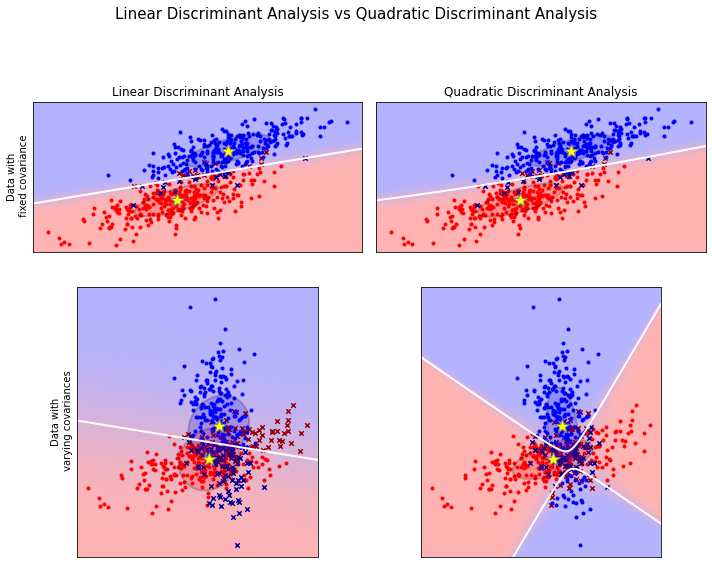

In [41]:
# #############################################################################
# Generate datasets

n_samples = 300 # initial value: 300
mean_1 = [1,1] # Original uses [1,1]
mean_2 = [1,4] # Original uses [1,4]

def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n = n_samples
    dim = 2  # Initial value 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    # C = np.array([[1, 0], [0, 1]]) # Use me for uniform covariance
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array(mean_1)]
    y = np.hstack((np.zeros(n, np.int8), np.ones(n, np.int8)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n = n_samples
    dim = 2  # Initial value 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    # C = np.array([[1, 0], [0, 1]]) # Use me for uniform covariance
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array(mean_2)]
    y = np.hstack((np.zeros(n, np.int8), np.ones(n, np.int8)))
    return X, y


plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
             y=0.98, fontsize=15)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')
    plt.gca().set_aspect('equal')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# PCA with Gaussian datasets

Original parameters demonstrate cases when LDA & QDA both outperform PCA.

Increase the impact of class-dependent mean on overall dataset covariance to show PCA performance improves with class separation. 

Exercise, change `mean_1 = [1,1]` to `mean_1 = [10,1]` to see improvement in PCA.

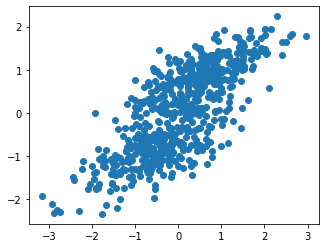

[[1.00166945 0.7673142 ]
 [0.7673142  1.00166945]]

Eigenvalues (before): [1.76898365 0.23435525]
Eigenvalues (after): [1.76898365 0.23435525]
COV for class 0: [[0.75738252 0.34508147]
 [0.34508147 0.32052207]]
COV for class 1: [[0.70748495 0.32112442]
 [0.32112442 0.28603519]]


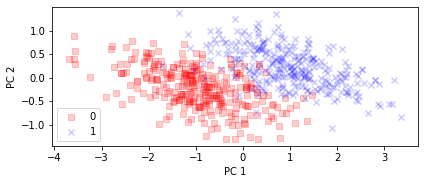

In [42]:
from sklearn.preprocessing import StandardScaler

X, y = dataset_fixed_cov() # Use this for uniform covariance
# X, y = dataset_cov() # Use this for class-dependent covariance

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Scatterplot of the data
plt.scatter(X[:,0], X[:,1])
plt.gca().set_aspect('equal')
plt.show()


cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print(cov_mat)

# Make sure eigenvalues (and associated eigenvectors) are decreasing order
print('\nEigenvalues (before):', eigen_vals)
w = eigen_vecs
if eigen_vals[1] > eigen_vals[0]:
  eigen_vals = eigen_vals[[1,0]]
  w = eigen_vecs[:,[1,0]]
print('Eigenvalues (after):', eigen_vals)

X_pca = X.dot(w)
markers = ['s', 'x']

# Scatterplot of the principal components, with color-coded classes
for k, c, m in zip(np.unique(y), ['red', 'blue'], markers):
    cov = np.cov(X[y==k,:].T)
    print('COV for class {}:'.format(k), cov)
    plt.scatter(X_pca[y == k, 0], 
                X_pca[y == k, 1], 
                c=c, label=k, marker=m, alpha=.2)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout();
plt.gca().set_aspect('equal')